In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lxml import objectify
from lxml import etree
import numpy as np
import copy
import sys
sys.path.append('..')
from blimp.utils.parse_markpoints import ParseMarkpoints

from blimp.utils.utils import threshold_detect

%matplotlib notebook

In [2]:
to_pv = '/home/jamesrowland/Desktop/2019-04-10_testIGI_001/SpiralsAllTrials.dat'
to_slm = '/home/jamesrowland/Desktop/2019-04-10_testIGI_001/SLMAllTrials.dat'
xml_path = '/home/jamesrowland/Desktop/2019-04-10_testIGI_001/2019-04-10_testIGI_001.xml'
gpl_path = '/home/jamesrowland/Desktop/2019-04-10_testIGI_001/2019-04-10_testIGI_001.gpl'

In [3]:
naparm_rate = 1000
num_groups = 4

In [4]:
pm = ParseMarkpoints(xml_path=xml_path, gpl_path=gpl_path)

durations = pm.durations
repetitions = pm.repetitions


In [23]:
pv_arr = np.fromfile(to_pv, dtype=float)
slm_arr = np.fromfile(to_slm, dtype=float)

slm_times = threshold_detect(slm_arr, 1)
pv_times = threshold_detect(pv_arr, 1)

n_repeats = len(slm_times) / num_groups
assert n_repeats.is_integer()
n_repeats = int(n_repeats)





slm_diff = np.diff(slm_times)
# time difference between groups on each trial
inter_group_intervals = slm_diff[0:num_groups-1]
#the time difference between groups of stimulations
inter_trial_interval = slm_diff[num_groups-1]



In [6]:
differ = np.diff(slm_times)

differ[num_groups-1]

700

<IPython.core.display.Javascript object>


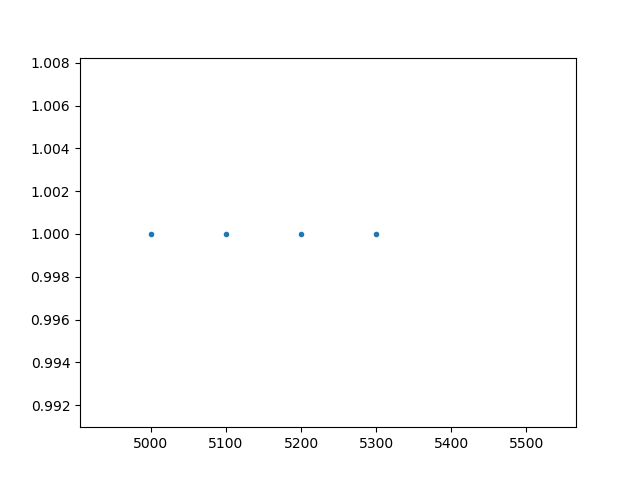

In [11]:
plt.plot(slm_times,np.ones(len(slm_times)),'.')

In [10]:
1/0

ZeroDivisionError: division by zero

In [15]:



tree = etree.parse(xml_path)
root = tree.getroot()

markpoint_elems = root.findall('PVMarkPointElement')

stim_length = int(durations[0]) * int(repetitions[0])

for i,point in enumerate(markpoint_elems):

    if i == 0:
        assert point.attrib['UncagingLaserPower'] == '0', 'Need to use naparm with dummy'
        #dont change the dummy
        continue

    # mutate xml elems so no external trigger required    
    point.attrib['TriggerFrequency'] = 'Never'
    
    galvo_elem_point = next(node for node in point.getiterator() if node.tag == 'PVGalvoPointElement')
    
    #information about each group from ParseMarkpoints does not include dummy
    group_idx = i-1
    
    stim_length = int(durations[group_idx]) * int(repetitions[group_idx])
    # this is a diff so has len durations - 1
    inter_group_interval = inter_group_intervals[group_idx-1]
    
    if i == 1:  
        #the first group should be delayed by the intertrial interval.
        # This means that the onset of stimulation will be delay by the inter-trial-interval
        galvo_elem_point.attrib['InitialDelay']  = str(inter_trial_interval)
    else:
        galvo_elem_point.attrib['InitialDelay'] = str(inter_group_interval - stim_length)

    #add the trigger lasers
    slm_trigger = copy.deepcopy(point)

    slm_trigger.attrib['UncagingLaser'] = 'Trigger'
    slm_trigger.attrib['UncagingLaserPower'] = '5' #volts (1000 PV)
    slm_trigger.attrib['AsyncSyncFrequency'] = 'None'
    slm_trigger.attrib['Repetitions'] = '1'

    galvo_elem_slm = next(node for node in slm_trigger.getiterator() if node.tag == 'PVGalvoPointElement')

    galvo_elem_slm.attrib['InitialDelay'] = '0'
    galvo_elem_slm.attrib['Duration'] = '1'
    galvo_elem_slm.attrib['SpiralRevolutions'] = '1'


    if i != len(markpoint_elems) - 1:
        parent = point.getparent()
        parent.insert(parent.index(point)+1, slm_trigger)

# self.autoxml_path = self.xml_path[:-4] + '_AutoNaparmXML.xml'        


# tree.write(self.autoxml_path)

# self.pl.SendScriptCommands('-LoadMarkPoints {}'.format(self.autoxml_path))
# self.pl.SendScriptCommands('-LoadMarkPoints {} True'.format(self.gpl_path))
        

10
hello
10
hello
10
hello


In [ ]:
len(markpoint_elems)

In [ ]:
plt.plot(slm_arr, '.')